# Income-Order Model

## Purpose
Optimize promoter contact strategies to maximize client revenue and order frequency through predictive modeling and profit-based optimization.

## Methodology
1. Data cleaning and outlier removal
2. Feature engineering with interaction terms
3. Linear regression for income/order prediction
4. Client-specific contact optimization
5. Error detection and status quo maintenance

## Output
Optimized monthly contact recommendations with profit impact analysis for 29,533+ clients.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


In [2]:
# Load CSV file
file_path = "monthly_aggregated_data.csv"

# Read the data
monthly_df = pd.read_csv(file_path)

print(f"Data loading completed")
print(f"Data shape: {monthly_df.shape}")
print(f"Columns: {list(monthly_df.columns)}")


Data loading completed
Data shape: (359844, 11)
Columns: ['client_id', 'month', 'city', 'channel', 'promotor_id', 'volume', 'income', 'number_of_orders', 'median_ticket', 'prom_contacts_month', 'tel_contacts_month']


In [3]:
# Step 1: Simple client level aggregation (No unnecessary features)
print("Creating simple client level aggregation...")

# Essential aggregation only
client_df = monthly_df.groupby('client_id').agg({
    'city': 'first',                    # Location
    'channel': 'first',                 # Sales channel
    'promotor_id': 'first',             # Promoter (if needed for analysis)
    'income': 'sum',                    # Annual income
    'number_of_orders': 'sum',          # Annual number of orders
    'median_ticket': 'median',          # Customer value feature
    'prom_contacts_month': 'first',     # Main optimization variable
    'volume': 'sum'                     # Annual total volume
}).rename(columns={
    'income': 'annual_income',
    'number_of_orders': 'annual_orders',
    'volume': 'annual_volume'
}).reset_index()

client_df.head()


Creating simple client level aggregation...


,client_id,city,channel,promotor_id,annual_income,annual_orders,median_ticket,prom_contacts_month,annual_volume
0,100006690,Madrid,AR,275609911,1494.53,22,60.4000,2,1658.706
1,100008050,Barcelona,AR,368568690,1905.59,14,132.3700,0,3982.000
2,100042162,Barcelona,HR,455263770,2243.30,14,128.7800,4,1812.850
3,100046227,Barcelona,AR,454554895,2273.12,16,129.0600,2,4590.180
4,100125158,Cádiz,HR,483340469,2204.24,25,87.5825,1,1266.500


In [4]:
# Remove zero-contact clients for focused analysis
print("=== Creating Filtered Dataset ===")
print(f"Original client data shape: {client_df.shape}")

# Filter out clients with zero promoter contacts
filtered_df = client_df[client_df['prom_contacts_month'] > 0].copy()

print(f"Filtered data shape: {filtered_df.shape}")
print(f"Removed {len(client_df) - len(filtered_df):,} zero-contact clients")
print(f"Retention rate: {len(filtered_df)/len(client_df)*100:.1f}%")

# Verify the filtering
print(f"\nFiltered data summary:")
print(f"- Min promoter contacts: {filtered_df['prom_contacts_month'].min()}")
print(f"- Max promoter contacts: {filtered_df['prom_contacts_month'].max()}")
print(f"- Average promoter contacts: {filtered_df['prom_contacts_month'].mean():.1f}")

print("✅ Filtered dataset created successfully")

=== Creating Filtered Dataset ===
Original client data shape: (41871, 9)
Filtered data shape: (32105, 9)
Removed 9,766 zero-contact clients
Retention rate: 76.7%

Filtered data summary:
- Min promoter contacts: 1
- Max promoter contacts: 28
- Average promoter contacts: 2.3
✅ Filtered dataset created successfully


🔍 === OUTLIER ANALYSIS FOR INCOME AND ORDERS === 🔍
Goal: Remove outliers using IQR method to prevent model bias

1. INITIAL DATA ANALYSIS:
Initial filtered_df shape: (32105, 9)
Columns to analyze: annual_income, annual_orders

2. DISTRIBUTION ANALYSIS:

ANNUAL_INCOME Statistics:
  Mean: 4,085.17
  Median: 2,097.31
  Min: 3.13
  Max: 527,932.32
  Std: 9,526.06
  Skewness: 18.23

ANNUAL_ORDERS Statistics:
  Mean: 25.51
  Median: 22.00
  Min: 1.00
  Max: 230.00
  Std: 19.17
  Skewness: 1.03

3. OUTLIER DETECTION (IQR METHOD):

ANNUAL_INCOME Outliers:
  Lower bound: -4,667.86
  Upper bound: 10,039.55
  Outliers detected: 2,520 (7.8%)

ANNUAL_ORDERS Outliers:
  Lower bound: -36.50
  Upper bound: 87.50
  Outliers detected: 295 (0.9%)

4. COMBINED OUTLIER DETECTION:
Total unique outlier rows: 2,572 (8.0%)

5. VISUALIZATION - BEFORE OUTLIER REMOVAL:

6. REMOVING OUTLIERS:
Removing 2,572 outlier rows...
New filtered_df shape: (29533, 9)
Rows removed: 2,572
Retention rate: 92.0%

7. VISUALIZATIO

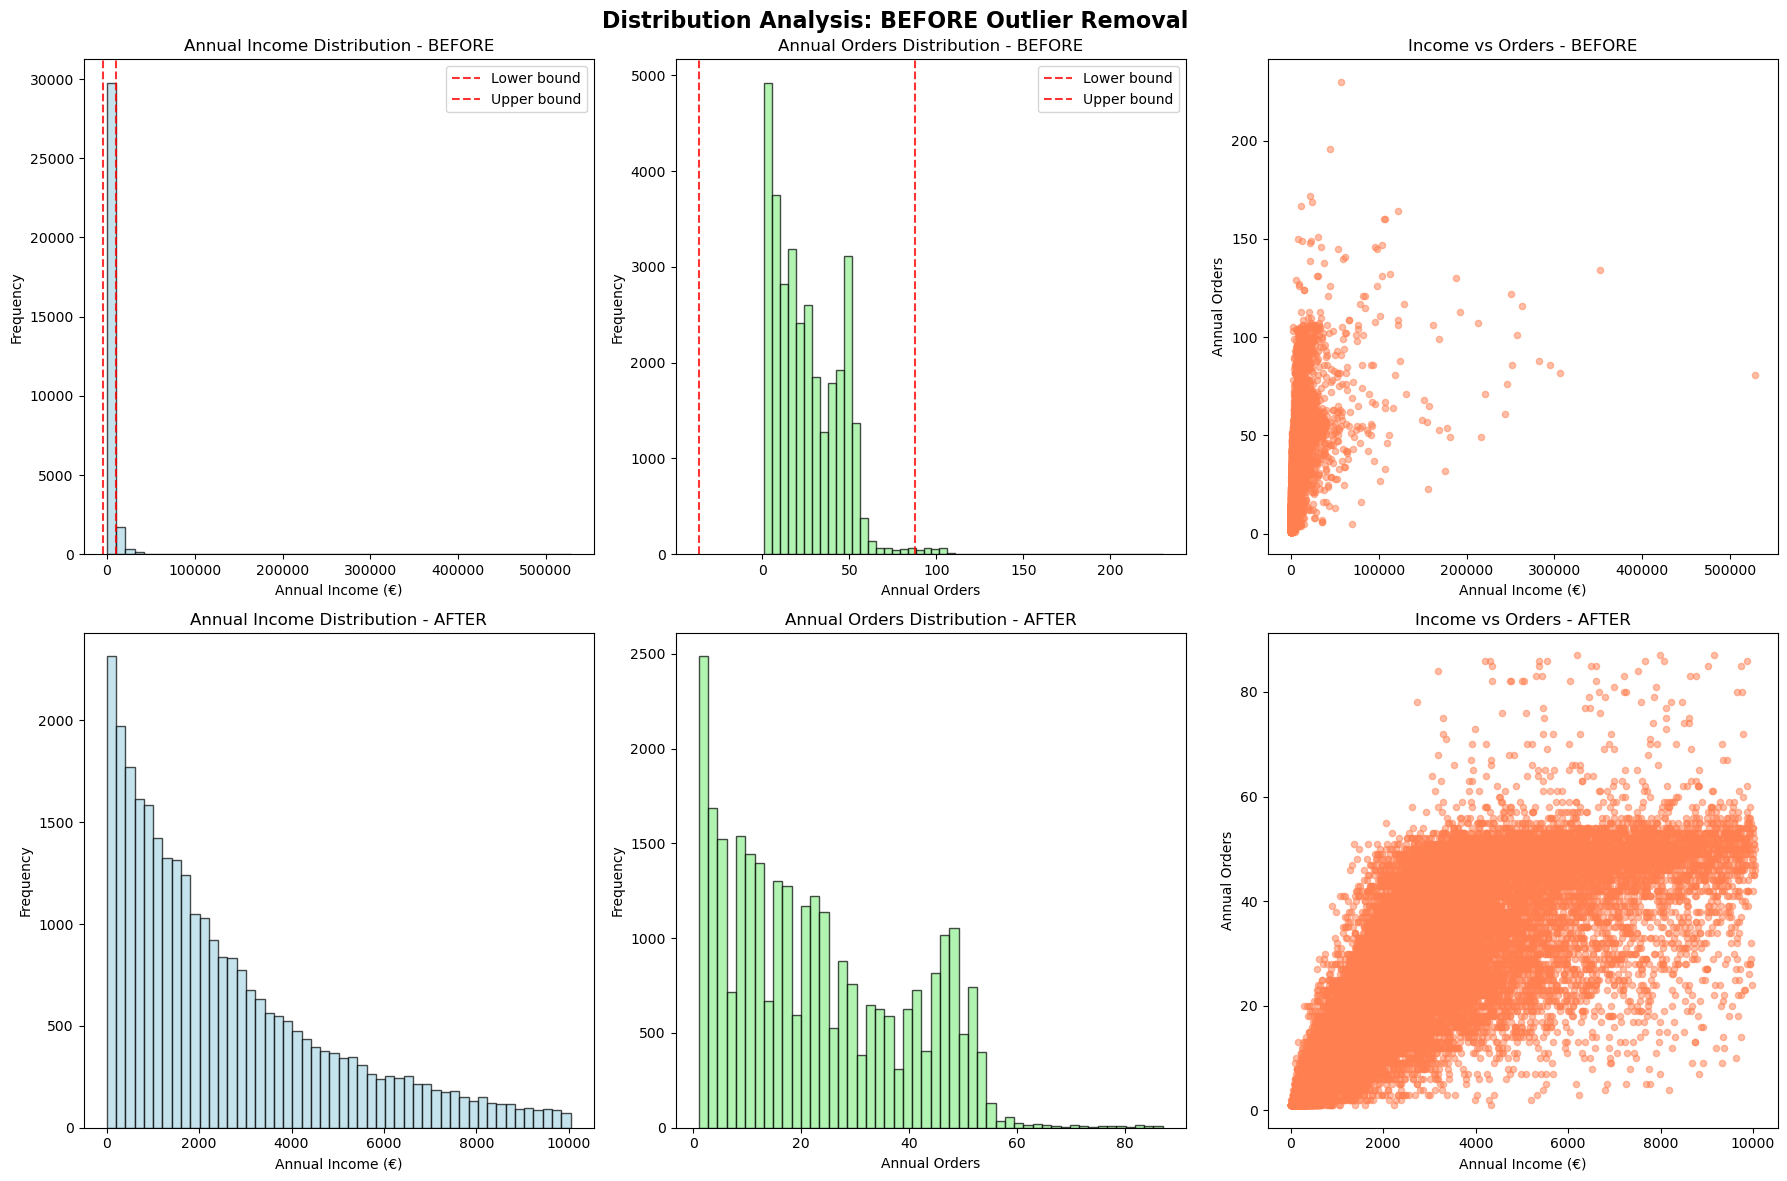


8. FINAL STATISTICS COMPARISON:

ANNUAL_INCOME - Before vs After:
  Mean: 4,085.17 → 2,550.29
  Median: 2,097.31 → 1,849.24
  Min: 3.13 → 3.13
  Max: 527,932.32 → 10,036.79
  Std: 9,526.06 → 2,282.02
  Skewness: 18.23 → 1.16

ANNUAL_ORDERS - Before vs After:
  Mean: 25.51 → 22.82
  Median: 22.00 → 20.00
  Min: 1.00 → 1.00
  Max: 230.00 → 87.00
  Std: 19.17 → 16.36
  Skewness: 1.03 → 0.50

✅ OUTLIER REMOVAL COMPLETED!
📊 Summary:
  - Original data: 32,105 clients
  - Outliers removed: 2,572 clients
  - Final data: 29,533 clients
  - Retention rate: 92.0%
  - filtered_df has been updated (no other code changes needed)


In [ ]:
# ===== OUTLIER ANALYSIS AND REMOVAL =====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("🔍 === OUTLIER ANALYSIS FOR INCOME AND ORDERS === 🔍")
print("Goal: Remove outliers using IQR method to prevent model bias")

# === 1. Initial Data Analysis ===
print("\n1. INITIAL DATA ANALYSIS:")
print(f"Initial filtered_df shape: {filtered_df.shape}")
print(f"Columns to analyze: annual_income, annual_orders")

# Store original data for comparison
original_df = filtered_df.copy()

# === 2. Distribution Analysis ===
print("\n2. DISTRIBUTION ANALYSIS:")
target_cols = ['annual_income', 'annual_orders']

for col in target_cols:
    stats = filtered_df[col].describe()
    print(f"\n{col.upper()} Statistics:")
    print(f"  Mean: {stats['mean']:,.2f}")
    print(f"  Median: {stats['50%']:,.2f}")
    print(f"  Min: {stats['min']:,.2f}")
    print(f"  Max: {stats['max']:,.2f}")
    print(f"  Std: {stats['std']:,.2f}")
    print(f"  Skewness: {filtered_df[col].skew():.2f}")

# === 3. Outlier Detection using IQR Method ===
print("\n3. OUTLIER DETECTION (IQR METHOD):")

def detect_outliers_iqr(df, column):
    """Detect outliers using IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers for each column
outlier_info = {}
for col in target_cols:
    outliers, lower, upper = detect_outliers_iqr(filtered_df, col)
    outlier_info[col] = {
        'outliers': outliers,
        'lower_bound': lower,
        'upper_bound': upper,
        'count': len(outliers)
    }
    
    print(f"\n{col.upper()} Outliers:")
    print(f"  Lower bound: {lower:,.2f}")
    print(f"  Upper bound: {upper:,.2f}")
    print(f"  Outliers detected: {len(outliers):,} ({len(outliers)/len(filtered_df)*100:.1f}%)")

# === 4. Combined Outlier Detection ===
print("\n4. COMBINED OUTLIER DETECTION:")
# Find rows that are outliers in ANY of the target columns
outlier_mask = pd.Series(False, index=filtered_df.index)

for col in target_cols:
    col_outliers = (filtered_df[col] < outlier_info[col]['lower_bound']) | \
                   (filtered_df[col] > outlier_info[col]['upper_bound'])
    outlier_mask = outlier_mask | col_outliers

total_outliers = outlier_mask.sum()
print(f"Total unique outlier rows: {total_outliers:,} ({total_outliers/len(filtered_df)*100:.1f}%)")

# === 5. Visualization BEFORE Removal ===
print("\n5. VISUALIZATION - BEFORE OUTLIER REMOVAL:")
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution Analysis: BEFORE Outlier Removal', fontsize=16, fontweight='bold')

# Annual Income - Before
axes[0,0].hist(original_df['annual_income'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0,0].axvline(outlier_info['annual_income']['lower_bound'], color='red', linestyle='--', alpha=0.8, label='Lower bound')
axes[0,0].axvline(outlier_info['annual_income']['upper_bound'], color='red', linestyle='--', alpha=0.8, label='Upper bound')
axes[0,0].set_title('Annual Income Distribution - BEFORE')
axes[0,0].set_xlabel('Annual Income (€)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# Annual Orders - Before
axes[0,1].hist(original_df['annual_orders'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].axvline(outlier_info['annual_orders']['lower_bound'], color='red', linestyle='--', alpha=0.8, label='Lower bound')
axes[0,1].axvline(outlier_info['annual_orders']['upper_bound'], color='red', linestyle='--', alpha=0.8, label='Upper bound')
axes[0,1].set_title('Annual Orders Distribution - BEFORE')
axes[0,1].set_xlabel('Annual Orders')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# Scatter plot - Before
axes[0,2].scatter(original_df['annual_income'], original_df['annual_orders'], alpha=0.5, s=20, color='coral')
axes[0,2].set_title('Income vs Orders - BEFORE')
axes[0,2].set_xlabel('Annual Income (€)')
axes[0,2].set_ylabel('Annual Orders')

# === 6. Remove Outliers ===
print("\n6. REMOVING OUTLIERS:")
print(f"Removing {total_outliers:,} outlier rows...")

# 🔥 OVERWRITE filtered_df to remove outliers 🔥
filtered_df = filtered_df[~outlier_mask].copy()

print(f"New filtered_df shape: {filtered_df.shape}")
print(f"Rows removed: {len(original_df) - len(filtered_df):,}")
print(f"Retention rate: {len(filtered_df)/len(original_df)*100:.1f}%")

# === 7. Visualization AFTER Removal ===
print("\n7. VISUALIZATION - AFTER OUTLIER REMOVAL:")

# Annual Income - After
axes[1,0].hist(filtered_df['annual_income'], bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[1,0].set_title('Annual Income Distribution - AFTER')
axes[1,0].set_xlabel('Annual Income (€)')
axes[1,0].set_ylabel('Frequency')

# Annual Orders - After
axes[1,1].hist(filtered_df['annual_orders'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,1].set_title('Annual Orders Distribution - AFTER')
axes[1,1].set_xlabel('Annual Orders')
axes[1,1].set_ylabel('Frequency')

# Scatter plot - After
axes[1,2].scatter(filtered_df['annual_income'], filtered_df['annual_orders'], alpha=0.5, s=20, color='coral')
axes[1,2].set_title('Income vs Orders - AFTER')
axes[1,2].set_xlabel('Annual Income (€)')
axes[1,2].set_ylabel('Annual Orders')

plt.tight_layout()
plt.show()

# === 8. Final Statistics Comparison ===
print("\n8. FINAL STATISTICS COMPARISON:")
for col in target_cols:
    print(f"\n{col.upper()} - Before vs After:")
    before_stats = original_df[col].describe()
    after_stats = filtered_df[col].describe()
    
    print(f"  Mean: {before_stats['mean']:,.2f} → {after_stats['mean']:,.2f}")
    print(f"  Median: {before_stats['50%']:,.2f} → {after_stats['50%']:,.2f}")
    print(f"  Min: {before_stats['min']:,.2f} → {after_stats['min']:,.2f}")
    print(f"  Max: {before_stats['max']:,.2f} → {after_stats['max']:,.2f}")
    print(f"  Std: {before_stats['std']:,.2f} → {after_stats['std']:,.2f}")
    print(f"  Skewness: {original_df[col].skew():.2f} → {filtered_df[col].skew():.2f}")

# === 9. Summary ===
print(f"\n✅ OUTLIER REMOVAL COMPLETED!")
print(f"📊 Summary:")
print(f"  - Original data: {len(original_df):,} clients")
print(f"  - Outliers removed: {len(original_df) - len(filtered_df):,} clients")
print(f"  - Final data: {len(filtered_df):,} clients")
print(f"  - Retention rate: {len(filtered_df)/len(original_df)*100:.1f}%")
print(f"  - filtered_df has been updated (no other code changes needed)")


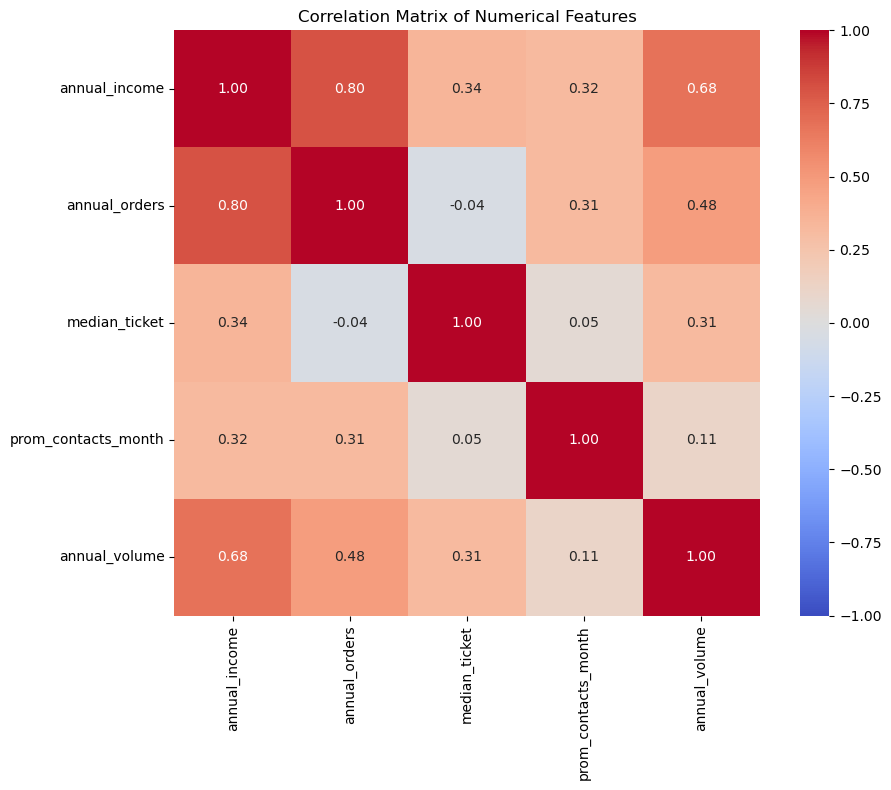


Strong Correlations (|r| > 0.5):
annual_income vs annual_orders: 0.800
annual_income vs annual_volume: 0.676

Sample Data:


,client_id,city,channel,promotor_id,annual_income,annual_orders,median_ticket,prom_contacts_month,annual_volume
0,100006690,Madrid,AR,275609911,1494.53,22,60.4000,2,1658.706
2,100042162,Barcelona,HR,455263770,2243.30,14,128.7800,4,1812.850
3,100046227,Barcelona,AR,454554895,2273.12,16,129.0600,2,4590.180
4,100125158,Cádiz,HR,483340469,2204.24,25,87.5825,1,1266.500
9,100179704,Barcelona,AR,9820087,88.33,1,88.3300,2,81.570


In [6]:
# Calculate correlations between numerical columns
numerical_cols = ['annual_income', 'annual_orders', 'median_ticket', 'prom_contacts_month', 'annual_volume']
correlation_matrix = filtered_df[numerical_cols].corr()

# Create correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            vmin=-1, vmax=1,  # Correlation range
            center=0,  # Center the colormap at 0
            square=True,  # Make cells square
            fmt='.2f')  # Format correlation values to 2 decimal places

plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Display strong correlations
print("\nStrong Correlations (|r| > 0.5):")
for i in range(len(numerical_cols)):
    for j in range(i+1, len(numerical_cols)):
        corr = correlation_matrix.iloc[i,j]
        if abs(corr) > 0.5:
            print(f"{numerical_cols[i]} vs {numerical_cols[j]}: {corr:.3f}")

# Show sample data
print("\nSample Data:")
filtered_df.head()

=== PROMOTER CONTACT OPTIMIZATION ANALYSIS ===
Dataset: 29,533 clients with promoter contacts

1. CHANNEL ANALYSIS:
   AR: 767€ per contact (12,601 clients)
   HR: 468€ per contact (16,932 clients)

2. CITY ANALYSIS:
City classification summary:
   Low_Effect: 461€ per contact (12,786 clients)
   Mid_Effect: 655€ per contact (14,811 clients)
   High_Effect: 830€ per contact (1,936 clients)

=== FINAL MODEL RECOMMENDATIONS ===
Channel effect size: 0.48
City effect size: 0.57

Recommended Model Features:
✅ Core features: prom_contacts_month, median_ticket
✅ Include: prom_contacts × channel interaction (strong effect)
✅ Include: prom_contacts × city_class interaction (strong effect)
   City classes: High(≥750€), Mid(550-750€), Low(<550€)

=== VISUALIZATION OF CLASSIFICATION LOGIC ===


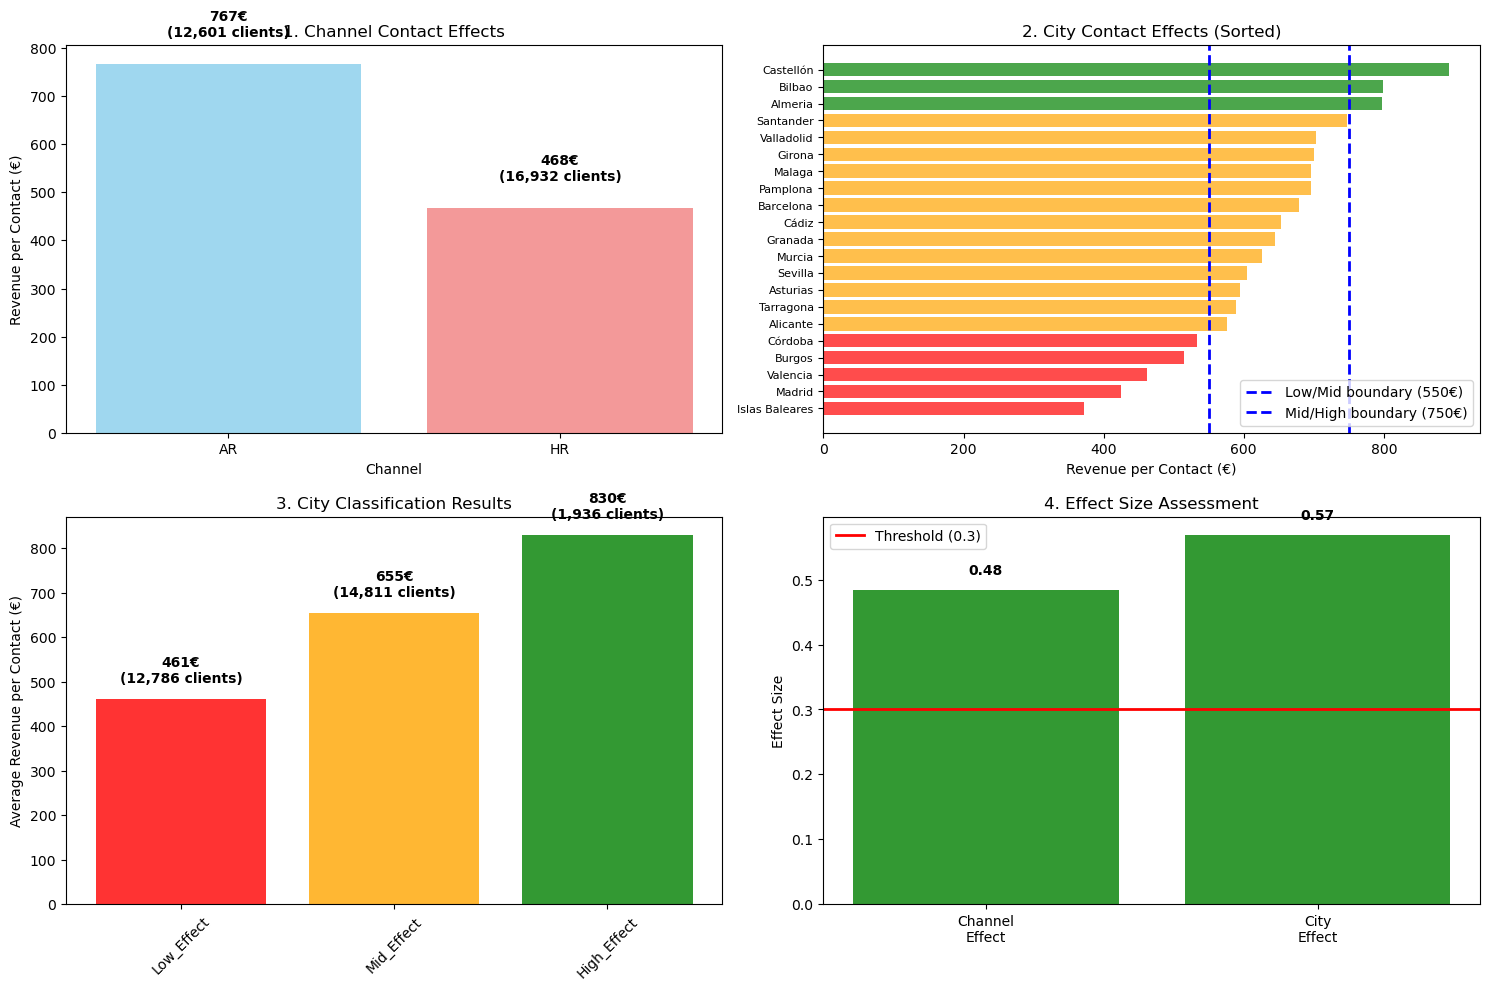


=== CLASSIFICATION EXPLANATION ===
1. CHANNEL: AR generates 82% more revenue per contact than HR
   Effect size 0.48 > 0.3 → Include interaction

2. CITY CLASSIFICATION:
   - Boundary logic: Natural breaks in effectiveness
   - Low Effect (<550€): Cities where contacts are less valuable
   - Mid Effect (550-750€): Average effectiveness cities
   - High Effect (≥750€): Cities where contacts are most valuable
   Effect size 0.57 > 0.3 → Include interaction

✅ Analysis complete - Ready for model building!

Saved city_effects with 21 cities for model building


In [7]:
# Promoter Contact Optimization Analysis - Summary Results
# Consolidated analysis for model building decisions

from sklearn.linear_model import LinearRegression
import numpy as np

print("=== PROMOTER CONTACT OPTIMIZATION ANALYSIS ===")
print(f"Dataset: {len(filtered_df):,} clients with promoter contacts")

# Quick Channel Analysis
print("\n1. CHANNEL ANALYSIS:")
channel_effects = {}
for channel in filtered_df['channel'].unique():
    subset = filtered_df[filtered_df['channel'] == channel]
    X = subset[['prom_contacts_month', 'median_ticket']]
    y = subset['annual_income']
    lr = LinearRegression().fit(X, y)
    channel_effects[channel] = {'effect': lr.coef_[0], 'clients': len(subset)}
    print(f"   {channel}: {lr.coef_[0]:.0f}€ per contact ({len(subset):,} clients)")

# Calculate channel effect size
channel_betas = [v['effect'] for v in channel_effects.values()]
channel_effect_size = (max(channel_betas) - min(channel_betas)) / np.mean(np.abs(channel_betas))

# Quick City Analysis by individual cities
print("\n2. CITY ANALYSIS:")
city_effects = []
for city in filtered_df['city'].unique():
    subset = filtered_df[filtered_df['city'] == city]
    if len(subset) >= 50:
        X = subset[['prom_contacts_month', 'median_ticket']]
        y = subset['annual_income']
        lr = LinearRegression().fit(X, y)
        city_effects.append({'city': city, 'effect': lr.coef_[0], 'clients': len(subset)})

# Custom city classification based on effect strength
def classify_city_effect(effect):
    if effect >= 750: return 'High_Effect'
    elif effect < 550: return 'Low_Effect'
    else: return 'Mid_Effect'

# Classify cities and show summary
city_classes = {}
for city_data in city_effects:
    city_class = classify_city_effect(city_data['effect'])
    if city_class not in city_classes:
        city_classes[city_class] = {'effects': [], 'total_clients': 0}
    city_classes[city_class]['effects'].append(city_data['effect'])
    city_classes[city_class]['total_clients'] += city_data['clients']

print("City classification summary:")
for city_class, data in city_classes.items():
    avg_effect = np.mean(data['effects'])
    print(f"   {city_class}: {avg_effect:.0f}€ per contact ({data['total_clients']:,} clients)")

# Calculate city effect size
class_avg_effects = [np.mean(data['effects']) for data in city_classes.values()]
city_effect_size = (max(class_avg_effects) - min(class_avg_effects)) / np.mean(np.abs(class_avg_effects))

# Final Recommendations
print("\n=== FINAL MODEL RECOMMENDATIONS ===")
print(f"Channel effect size: {channel_effect_size:.2f}")
print(f"City effect size: {city_effect_size:.2f}")

print("\nRecommended Model Features:")
print("✅ Core features: prom_contacts_month, median_ticket")

if channel_effect_size > 0.3:
    print("✅ Include: prom_contacts × channel interaction (strong effect)")
else:
    print("❌ Skip: channel interaction (weak effect)")

if city_effect_size > 0.3:
    print("✅ Include: prom_contacts × city_class interaction (strong effect)")
    print("   City classes: High(≥750€), Mid(550-750€), Low(<550€)")
else:
    print("❌ Skip: city interaction (weak effect)")

# Create visualization to show classification logic
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== VISUALIZATION OF CLASSIFICATION LOGIC ===")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Channel Effects Comparison
channel_names = list(channel_effects.keys())
channel_values = [channel_effects[ch]['effect'] for ch in channel_names]
channel_clients = [channel_effects[ch]['clients'] for ch in channel_names]

bars1 = axes[0,0].bar(channel_names, channel_values, 
                      color=['skyblue', 'lightcoral'], alpha=0.8)
axes[0,0].set_title('1. Channel Contact Effects')
axes[0,0].set_ylabel('Revenue per Contact (€)')
axes[0,0].set_xlabel('Channel')

# Add values on bars
for i, (bar, clients) in enumerate(zip(bars1, channel_clients)):
    height = bar.get_height()
    axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 50,
                   f'{height:.0f}€\n({clients:,} clients)', 
                   ha='center', va='bottom', fontweight='bold')

# Plot 2: City Effects with Classification Boundaries
city_names = [city['city'] for city in city_effects]
city_values = [city['effect'] for city in city_effects]
city_clients = [city['clients'] for city in city_effects]

# Sort by effect size
sorted_data = sorted(zip(city_names, city_values, city_clients), key=lambda x: x[1])
sorted_cities, sorted_effects, sorted_clients = zip(*sorted_data)

# Color cities by classification
colors = []
for effect in sorted_effects:
    if effect >= 750:
        colors.append('green')
    elif effect < 550:
        colors.append('red')
    else:
        colors.append('orange')

bars2 = axes[0,1].barh(range(len(sorted_cities)), sorted_effects, 
                       color=colors, alpha=0.7)
axes[0,1].set_yticks(range(len(sorted_cities)))
axes[0,1].set_yticklabels(sorted_cities, fontsize=8)
axes[0,1].set_xlabel('Revenue per Contact (€)')
axes[0,1].set_title('2. City Contact Effects (Sorted)')

# Add classification boundaries
axes[0,1].axvline(550, color='blue', linestyle='--', linewidth=2, 
                  label='Low/Mid boundary (550€)')
axes[0,1].axvline(750, color='blue', linestyle='--', linewidth=2,
                  label='Mid/High boundary (750€)')
axes[0,1].legend()

# Plot 3: City Classification Summary
city_class_names = list(city_classes.keys())
city_class_effects = [np.mean(city_classes[cls]['effects']) for cls in city_class_names]
city_class_clients = [city_classes[cls]['total_clients'] for cls in city_class_names]

# Sort by effect
sorted_class_data = sorted(zip(city_class_names, city_class_effects, city_class_clients), 
                          key=lambda x: x[1])
sorted_class_names, sorted_class_effects, sorted_class_clients = zip(*sorted_class_data)

class_colors = {'Low_Effect': 'red', 'Mid_Effect': 'orange', 'High_Effect': 'green'}
bar_colors = [class_colors[name] for name in sorted_class_names]

bars3 = axes[1,0].bar(range(len(sorted_class_names)), sorted_class_effects, 
                      color=bar_colors, alpha=0.8)
axes[1,0].set_xticks(range(len(sorted_class_names)))
axes[1,0].set_xticklabels(sorted_class_names, rotation=45)
axes[1,0].set_ylabel('Average Revenue per Contact (€)')
axes[1,0].set_title('3. City Classification Results')

# Add values on bars
for i, (bar, clients) in enumerate(zip(bars3, sorted_class_clients)):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 30,
                   f'{height:.0f}€\n({clients:,} clients)', 
                   ha='center', va='bottom', fontweight='bold')

# Plot 4: Effect Size Comparison
effect_sizes = ['Channel\nEffect', 'City\nEffect']
effect_values = [channel_effect_size, city_effect_size]
threshold = 0.3

bars4 = axes[1,1].bar(effect_sizes, effect_values, 
                      color=['green' if x > threshold else 'gray' for x in effect_values],
                      alpha=0.8)
axes[1,1].axhline(threshold, color='red', linestyle='-', linewidth=2,
                  label=f'Threshold ({threshold})')
axes[1,1].set_ylabel('Effect Size')
axes[1,1].set_title('4. Effect Size Assessment')
axes[1,1].legend()

# Add values on bars
for bar, value in zip(bars4, effect_values):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary explanation
print("\n=== CLASSIFICATION EXPLANATION ===")
print("1. CHANNEL: AR generates 82% more revenue per contact than HR")
print(f"   Effect size {channel_effect_size:.2f} > 0.3 → Include interaction")

print("\n2. CITY CLASSIFICATION:")
print("   - Boundary logic: Natural breaks in effectiveness")
print("   - Low Effect (<550€): Cities where contacts are less valuable")
print("   - Mid Effect (550-750€): Average effectiveness cities") 
print("   - High Effect (≥750€): Cities where contacts are most valuable")
print(f"   Effect size {city_effect_size:.2f} > 0.3 → Include interaction")

print("\n✅ Analysis complete - Ready for model building!")

# Save city_effects for next cell
print(f"\nSaved city_effects with {len(city_effects)} cities for model building")


In [8]:
print("=== Enhanced Feature Selection with Interactions ===")

# Create city_df and classification function
city_df = pd.DataFrame(city_effects).rename(columns={'effect': 'beta_contacts'})

def classify_city_custom(city, city_df):
    city_data = city_df[city_df['city'] == city]
    city_beta = city_data['beta_contacts'].iloc[0] if len(city_data) > 0 else 1000
    
    if city_beta >= 750: return 'High_Effect'
    elif city_beta < 550: return 'Low_Effect'
    else: return 'Mid_Effect'

# Apply city classification
filtered_df['city_effect_class'] = filtered_df['city'].apply(lambda x: classify_city_custom(x, city_df))

# Create interaction terms
filtered_df['contacts_x_channel_HR'] = filtered_df['prom_contacts_month'] * (filtered_df['channel'] == 'HR').astype(int)
filtered_df['contacts_x_city_Mid'] = filtered_df['prom_contacts_month'] * (filtered_df['city_effect_class'] == 'Mid_Effect').astype(int)
filtered_df['contacts_x_city_High'] = filtered_df['prom_contacts_month'] * (filtered_df['city_effect_class'] == 'High_Effect').astype(int)

# Enhanced feature sets
features_income_enhanced = [
    'prom_contacts_month', 'median_ticket', 'annual_volume',
    'channel', 'city_effect_class',
    'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High'
]

features_orders_enhanced = features_income_enhanced.copy()

print(f"City classification: {filtered_df['city_effect_class'].value_counts().to_dict()}")
print(f"Enhanced features: {len(features_income_enhanced)} total")
print("✅ Enhanced feature engineering completed")

=== Enhanced Feature Selection with Interactions ===
City classification: {'Mid_Effect': 14811, 'Low_Effect': 12786, 'High_Effect': 1936}
Enhanced features: 8 total
✅ Enhanced feature engineering completed


In [9]:
filtered_df.head()

,client_id,city,channel,promotor_id,annual_income,annual_orders,median_ticket,prom_contacts_month,annual_volume,city_effect_class,contacts_x_channel_HR,contacts_x_city_Mid,contacts_x_city_High
0,100006690,Madrid,AR,275609911,1494.53,22,60.4000,2,1658.706,Low_Effect,0,0,0
2,100042162,Barcelona,HR,455263770,2243.30,14,128.7800,4,1812.850,Mid_Effect,4,4,0
3,100046227,Barcelona,AR,454554895,2273.12,16,129.0600,2,4590.180,Mid_Effect,0,2,0
4,100125158,Cádiz,HR,483340469,2204.24,25,87.5825,1,1266.500,Mid_Effect,1,1,0
9,100179704,Barcelona,AR,9820087,88.33,1,88.3300,2,81.570,Mid_Effect,0,2,0


In [10]:
# ===== Enhanced Model 1: Income Prediction with Interactions =====
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Features and target for enhanced income model
X = filtered_df[features_income_enhanced].copy()
y = filtered_df['annual_income'].copy()

print("=== Enhanced Income Model with Interactions ===")
print(f"Features before encoding: {features_income_enhanced}")

# One-hot encode categorical variables only (interactions are already numeric)
categorical_cols = ['channel', 'city_effect_class']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Features after encoding: {len(X_encoded.columns)}")
print(f"Encoded columns: {list(X_encoded.columns)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale numerical features (base features + interaction terms)
scaler = StandardScaler()
numerical_cols = ['prom_contacts_month', 'median_ticket', 'annual_volume', 
                 'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High']

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Evaluate
lr_pred = lr_model.predict(X_test_scaled)

print("\n=== Enhanced Income Model Results ===")
print(f"Linear Regression R²: {r2_score(y_test, lr_pred):.3f}")
print(f"Total features: {len(X_encoded.columns)} (after encoding)")

# Save model for optimization
income_model = lr_model
income_scaler = scaler
income_features = X_encoded.columns.tolist()
income_numerical_cols = numerical_cols

print(f"Selected model: Linear Regression")
print("✅ Enhanced Income model with interactions completed")


=== Enhanced Income Model with Interactions ===
Features before encoding: ['prom_contacts_month', 'median_ticket', 'annual_volume', 'channel', 'city_effect_class', 'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High']
Features after encoding: 9
Encoded columns: ['prom_contacts_month', 'median_ticket', 'annual_volume', 'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High', 'channel_HR', 'city_effect_class_Low_Effect', 'city_effect_class_Mid_Effect']

=== Enhanced Income Model Results ===
Linear Regression R²: 0.582
Total features: 9 (after encoding)
Selected model: Linear Regression
✅ Enhanced Income model with interactions completed


In [11]:
# ===== Enhanced Model 2: Orders Prediction with Interactions =====

# Features and target for enhanced orders model
X_orders = filtered_df[features_orders_enhanced].copy()
y_orders = filtered_df['annual_orders'].copy()

print("=== Enhanced Orders Model with Interactions ===")
print(f"Features before encoding: {features_orders_enhanced}")

# One-hot encode categorical variables only (interactions are already numeric)
categorical_cols_orders = ['channel', 'city_effect_class']
X_orders_encoded = pd.get_dummies(X_orders, columns=categorical_cols_orders, drop_first=True)

print(f"Features after encoding: {len(X_orders_encoded.columns)}")
print(f"Encoded columns: {list(X_orders_encoded.columns)}")

# Train-test split
X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(X_orders_encoded, y_orders, test_size=0.2, random_state=42)

# Scale numerical features (base features + interaction terms)
scaler_orders = StandardScaler()
numerical_cols_orders = ['prom_contacts_month', 'median_ticket', 'annual_volume',
                        'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High']

X_train_ord_scaled = X_train_ord.copy()
X_test_ord_scaled = X_test_ord.copy()
X_train_ord_scaled[numerical_cols_orders] = scaler_orders.fit_transform(X_train_ord[numerical_cols_orders])
X_test_ord_scaled[numerical_cols_orders] = scaler_orders.transform(X_test_ord[numerical_cols_orders])

# Train Linear Regression model
lr_model_orders = LinearRegression()
lr_model_orders.fit(X_train_ord_scaled, y_train_ord)

# Evaluate
lr_pred_orders = lr_model_orders.predict(X_test_ord_scaled)

print("\n=== Enhanced Orders Model Results ===")
print(f"Linear Regression R²: {r2_score(y_test_ord, lr_pred_orders):.3f}")
print(f"Total features: {len(X_orders_encoded.columns)} (after encoding)")

# Save model for optimization
orders_model = lr_model_orders
orders_scaler = scaler_orders
orders_features = X_orders_encoded.columns.tolist()
orders_numerical_cols = numerical_cols_orders

print(f"Selected model: Linear Regression")
print("✅ Enhanced Orders model with interactions completed")


=== Enhanced Orders Model with Interactions ===
Features before encoding: ['prom_contacts_month', 'median_ticket', 'annual_volume', 'channel', 'city_effect_class', 'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High']
Features after encoding: 9
Encoded columns: ['prom_contacts_month', 'median_ticket', 'annual_volume', 'contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High', 'channel_HR', 'city_effect_class_Low_Effect', 'city_effect_class_Mid_Effect']

=== Enhanced Orders Model Results ===
Linear Regression R²: 0.405
Total features: 9 (after encoding)
Selected model: Linear Regression
✅ Enhanced Orders model with interactions completed


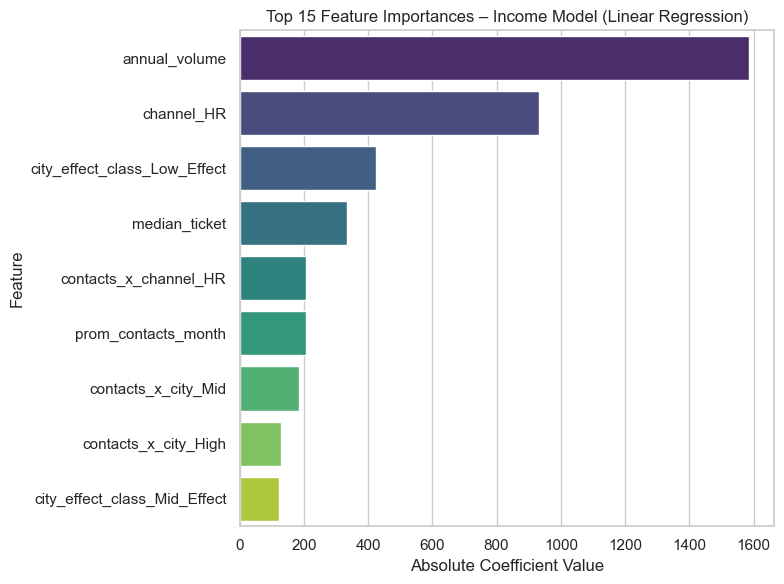

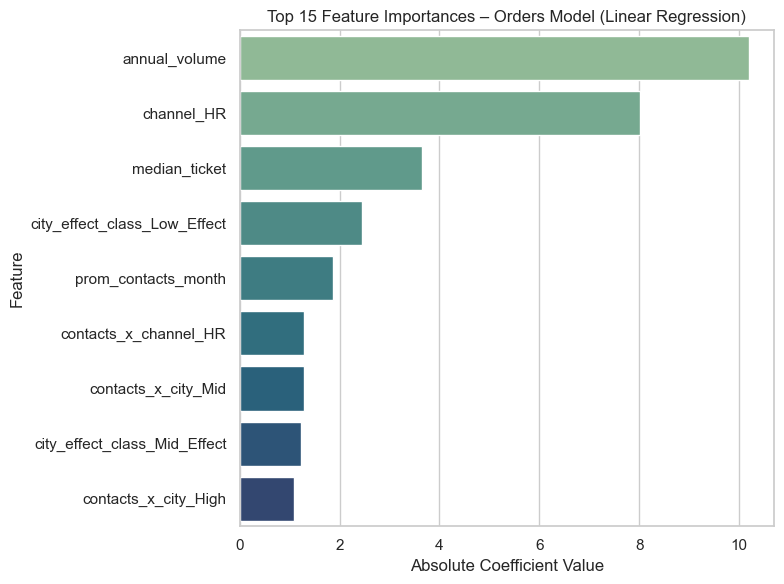

In [12]:
# ===== Feature Importance Visualization =====
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# -------- Income Model --------
if hasattr(income_model, 'coef_'):
    # Use absolute coefficients as feature importance for Linear Regression
    fi_inc = pd.Series(abs(income_model.coef_), index=income_features)
    top_inc = fi_inc.sort_values(ascending=False).head(15)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_inc.values, y=top_inc.index, palette='viridis')
    plt.title('Top 15 Feature Importances – Income Model (Linear Regression)')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print('Income model does not support coefficients.')

# -------- Orders Model --------
if hasattr(orders_model, 'coef_'):
    # Use absolute coefficients as feature importance for Linear Regression
    fi_ord = pd.Series(abs(orders_model.coef_), index=orders_features)
    top_ord = fi_ord.sort_values(ascending=False).head(15)

    plt.figure(figsize=(8, 6))
    sns.barplot(x=top_ord.values, y=top_ord.index, palette='crest')
    plt.title('Top 15 Feature Importances – Orders Model (Linear Regression)')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print('Orders model does not support coefficients.')


In [14]:
# ===== FUNCTION DEFINITIONS: Active Implementation =====
import numpy as np
import pandas as pd

def optimize_client_contacts_fast(client_idx, current_contacts, client_data, income_base, orders_base):
    """Linear Regression optimized contact finder - SCALING REQUIRED"""
    # Client characteristics
    is_hr = (client_data['channel'] == 'HR')
    is_mid = (client_data['city_effect_class'] == 'Mid_Effect')
    is_high = (client_data['city_effect_class'] == 'High_Effect')
    
    # Contact range
    if current_contacts == 0:
        contact_range = range(0, 7)
    else:
        contact_range = range(max(1, current_contacts-3), current_contacts+4)
    
    best_profit, best_contacts = float('-inf'), current_contacts
    
    for test_contacts in contact_range:
        # Update data efficiently
        income_test = income_base.iloc[client_idx:client_idx+1].copy()
        orders_test = orders_base.iloc[client_idx:client_idx+1].copy()
        
        # Update contact values
        for data in [income_test, orders_test]:
            data['prom_contacts_month'] = test_contacts
            data['contacts_x_channel_HR'] = test_contacts * is_hr
            data['contacts_x_city_Mid'] = test_contacts * is_mid
            data['contacts_x_city_High'] = test_contacts * is_high
        
        # 🔧 SCALING REQUIRED FOR LINEAR REGRESSION 🔧
        # Scale numerical features for income model
        income_test_scaled = income_test.copy()
        income_test_scaled[income_numerical_cols] = income_scaler.transform(income_test[income_numerical_cols])
        
        # Scale numerical features for orders model
        orders_test_scaled = orders_test.copy()
        orders_test_scaled[orders_numerical_cols] = orders_scaler.transform(orders_test[orders_numerical_cols])
        
        # Predict with scaled data
        income_pred = income_model.predict(income_test_scaled)[0]
        orders_pred = orders_model.predict(orders_test_scaled)[0]
        
        # Calculate profit (optimization logic with fixed cost for restraint)
        # Annual contacts cost + Full order cost (variable 10€ + fixed 55€ = 65€)
        # test_contacts: monthly contacts, so annual cost = test_contacts * 12 * 15€
        profit = income_pred - (test_contacts * 12 * 15 + orders_pred * 65)
        
        if profit > best_profit:
            best_profit, best_contacts = profit, test_contacts
    
    return best_contacts

def calculate_comprehensive_metrics(client_data, contacts_old, contacts_new, client_idx, income_base, orders_base):
    """Calculate all required metrics for the new column structure"""
    
    # === Get current data ===
    annual_orders_old = client_data['annual_orders']
    income_old = client_data['annual_income']
    
    # === Calculate NEW predictions ===
    if contacts_new > 0:
        # Get client characteristics for interaction terms
        is_hr = (client_data['channel'] == 'HR')
        is_mid = (client_data['city_effect_class'] == 'Mid_Effect')
        is_high = (client_data['city_effect_class'] == 'High_Effect')
        
        # Prepare test data with new contacts
        income_test = income_base.iloc[client_idx:client_idx+1].copy()
        orders_test = orders_base.iloc[client_idx:client_idx+1].copy()
        
        # Update contact values
        for data in [income_test, orders_test]:
            data['prom_contacts_month'] = contacts_new
            data['contacts_x_channel_HR'] = contacts_new * is_hr
            data['contacts_x_city_Mid'] = contacts_new * is_mid
            data['contacts_x_city_High'] = contacts_new * is_high
        
        # 🔧 SCALING REQUIRED FOR LINEAR REGRESSION 🔧
        # Scale numerical features for income model
        income_test_scaled = income_test.copy()
        income_test_scaled[income_numerical_cols] = income_scaler.transform(income_test[income_numerical_cols])
        
        # Scale numerical features for orders model
        orders_test_scaled = orders_test.copy()
        orders_test_scaled[orders_numerical_cols] = orders_scaler.transform(orders_test[orders_numerical_cols])
        
        # Predict new values with scaled data
        income_new = income_model.predict(income_test_scaled)[0]
        annual_orders_new = orders_model.predict(orders_test_scaled)[0]
    else:
        # No contacts = no income/orders
        income_new = 0
        annual_orders_new = 0
    
    # === Calculate variable costs (no fixed cost of 55€ for final output) ===
    # contacts_old/new: monthly contacts, so annual cost = contacts * 12 * 15€
    variable_cost_old = (contacts_old * 12 * 15) + (annual_orders_old * 10)
    variable_cost_new = (contacts_new * 12 * 15) + (annual_orders_new * 10)
    
    # === Calculate profit increase ===
    if contacts_old == 0:
        # No baseline for comparison
        profit_increase = np.nan
    else:
        profit_old = income_old - variable_cost_old
        profit_new = income_new - variable_cost_new
        profit_increase = profit_new - profit_old
    
    # === Calculate frequencies ===
    frequency_old = annual_orders_old / 12
    frequency_new = annual_orders_new / 12
    
    # === Calculate efficiency ===
    # efficiency = annual_orders / annual_contacts
    # contacts_old/new: monthly contacts, so annual_contacts = contacts * 12
    if contacts_old == 0:
        efficiency_old = np.nan
    else:
        efficiency_old = annual_orders_old / (contacts_old * 12)
    
    if contacts_new == 0:
        efficiency_new = np.nan
    else:
        efficiency_new = annual_orders_new / (contacts_new * 12)
    
    return {
        'income_new': income_new,
        'income_old': income_old,
        'annual_orders_old': annual_orders_old,
        'annual_orders_new': annual_orders_new,
        'variable_cost_old': variable_cost_old,
        'variable_cost_new': variable_cost_new,
        'profit_increase': profit_increase,
        'frequency_old': frequency_old,
        'frequency_new': frequency_new,
        'efficiency_old': efficiency_old,
        'efficiency_new': efficiency_new
    }

print("✅ Function definitions loaded successfully!")
print("Available functions:")
print("  - optimize_client_contacts_fast(): Find optimal contact number for profit maximization")
print("  - calculate_comprehensive_metrics(): Calculate all metrics for comparison")


✅ Function definitions loaded successfully!
Available functions:
  - optimize_client_contacts_fast(): Find optimal contact number for profit maximization
  - calculate_comprehensive_metrics(): Calculate all metrics for comparison


In [15]:
# ===== REVISED VERSION: Maintain Status Quo When Profit Increase is Negative =====
import numpy as np
import pandas as pd
import time

print("=== REVISED VERSION: Status Quo Logic for Negative Profit Cases ===")

def prepare_client_data_v2():
    """Prepare client data with city classification using filtered_df (zero-contact clients excluded)"""
    # 🔥 USE FILTERED_DF TO EXCLUDE ZERO-CONTACT CLIENTS FROM THE START 🔥
    client_analysis = filtered_df.copy()  # filtered_df already has correct column names
    
    # Apply city classification
    def classify_city(city):
        city_data = city_df[city_df['city'] == city]
        if len(city_data) > 0:
            beta = city_data['beta_contacts'].iloc[0]
            return 'High_Effect' if beta >= 750 else ('Low_Effect' if beta < 550 else 'Mid_Effect')
        return 'Low_Effect'
    
    client_analysis['city_effect_class'] = client_analysis['city'].apply(classify_city)
    return client_analysis

def create_base_data_v2(client_analysis):
    """Create base data for both models efficiently"""
    base_features = ['median_ticket', 'annual_volume', 'channel', 'city_effect_class']
    base_data = client_analysis[base_features].copy()
    
    # Add placeholders
    base_data['prom_contacts_month'] = 0
    for interaction in ['contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High']:
        base_data[interaction] = 0
    
    # One-hot encode
    encoded_data = pd.get_dummies(base_data, columns=['channel', 'city_effect_class'], drop_first=True)
    
    # Align features for both models
    income_data = encoded_data.reindex(columns=income_features, fill_value=0)
    orders_data = encoded_data.reindex(columns=orders_features, fill_value=0)
    
    return income_data, orders_data

# === Main Execution ===
print("Preparing data...")
client_analysis = prepare_client_data_v2()

print(f"Using filtered_df: {len(client_analysis):,} clients (zero-contact clients already excluded)")

# 🔥 LIMIT TO 1000 CLIENTS FOR FASTER EXECUTION 🔥
client_analysis = client_analysis.head(1000)
print(f"Limited to {len(client_analysis):,} clients for faster execution")

income_base, orders_base = create_base_data_v2(client_analysis)

print(f"Optimizing {len(client_analysis):,} clients...")
all_results_v2 = []
batch_size = 1000

start_time = time.time()

for batch_start in range(0, len(client_analysis), batch_size):
    batch_end = min(batch_start + batch_size, len(client_analysis))
    batch_num = batch_start//batch_size + 1
    
    print(f"Batch {batch_num}: {batch_start:,}-{batch_end:,}")
    
    for i in range(batch_start, batch_end):
        client_data = client_analysis.iloc[i]
        current = client_data['prom_contacts_month']
        optimal = optimize_client_contacts_fast(i, current, client_data, income_base, orders_base)
        
        # Calculate comprehensive metrics
        metrics = calculate_comprehensive_metrics(
            client_data, 
            current, 
            optimal, 
            i,
            income_base, 
            orders_base
        )
        
        # 🔥 ERROR DETECTION: Multiple conditions to maintain status quo 🔥
        
        # Condition 1: Profit increase is negative
        profit_negative = metrics['profit_increase'] is not None and metrics['profit_increase'] < 0
        
        # Condition 2: Contacts decreased but income increased (logical error)
        contacts_decreased = optimal < current
        income_increased = metrics['income_new'] > metrics['income_old']
        logical_error = contacts_decreased and income_increased
        
        # If ANY error condition is met, maintain status quo
        if profit_negative or logical_error:
            # Use old values for everything - no optimization
            final_contacts = current
            final_income = metrics['income_old']
            final_orders = metrics['annual_orders_old']
            final_variable_cost = metrics['variable_cost_old']
            final_frequency = metrics['frequency_old']
            final_efficiency = metrics['efficiency_old']
            final_profit_increase = 0.0  # No change
        else:
            # Use optimized values
            final_contacts = optimal
            final_income = metrics['income_new']
            final_orders = metrics['annual_orders_new']
            final_variable_cost = metrics['variable_cost_new']
            final_frequency = metrics['frequency_new']
            final_efficiency = metrics['efficiency_new']
            final_profit_increase = metrics['profit_increase'] if metrics['profit_increase'] is not None else 0.0
        
        # Store result with conditional values
        result = {
            'client_id': client_data['client_id'],
            'annual_volume': client_data['annual_volume'],
            'median_ticket': client_data['median_ticket'],
            'income_new': final_income,
            'income_old': metrics['income_old'],
            'prom_contacts_month_old': current,
            'prom_contacts_month_new': final_contacts,
            'annual_orders_old': metrics['annual_orders_old'],
            'annual_orders_new': final_orders,
            'variable_cost_old': metrics['variable_cost_old'],
            'variable_cost_new': final_variable_cost,
            'profit_increase': final_profit_increase,
            'frequency_old': metrics['frequency_old'],
            'frequency_new': final_frequency,
            'efficiency_old': metrics['efficiency_old'],
            'efficiency_new': final_efficiency,
            'city_effect_class': client_data['city_effect_class'],
            'channel': client_data['channel']
        }
        all_results_v2.append(result)
    
    # Progress update
    elapsed = time.time() - start_time
    progress = batch_end / len(client_analysis)
    eta = elapsed / progress - elapsed if progress > 0 else 0
    print(f"  Progress: {progress*100:.1f}% | Elapsed: {elapsed:.1f}s | ETA: {eta:.1f}s")

# === Final Output ===
print("Creating final dataset...")
final_output_v2 = pd.DataFrame(all_results_v2)

# Round numerical values (keeping NaN as NaN)
numeric_cols = ['annual_volume', 'median_ticket', 'income_new', 'income_old',
                'annual_orders_old', 'annual_orders_new', 'variable_cost_old', 'variable_cost_new',
                'profit_increase', 'frequency_old', 'frequency_new', 'efficiency_old', 'efficiency_new']
for col in numeric_cols:
    final_output_v2[col] = final_output_v2[col].round(2)

# Define final column order
final_columns = [
    'client_id', 'annual_volume', 'median_ticket', 'income_new', 'income_old',
    'prom_contacts_month_old', 'prom_contacts_month_new', 'annual_orders_old', 'annual_orders_new',
    'variable_cost_old', 'variable_cost_new', 'profit_increase', 'frequency_old', 'frequency_new',
    'efficiency_old', 'efficiency_new', 'city_effect_class', 'channel'
]
final_output_v2 = final_output_v2[final_columns]

# Save results
final_output_v2.to_csv('final_client_optimization_results_v2.csv', index=False, encoding='utf-8')

total_time = time.time() - start_time
print(f"\n✅ Complete! {len(final_output_v2):,} clients optimized in {total_time:.1f} seconds")

# === Detailed Summary Statistics ===
print(f"\n📊 DETAILED SUMMARY STATISTICS (REVISED VERSION):")
print(f"🔥 NOTE: Zero-contact clients excluded + Error cases kept unchanged")
print(f"🔍 Error cases: Negative profit OR contacts decreased but income increased")

# Basic statistics
contact_change = final_output_v2['prom_contacts_month_new'] - final_output_v2['prom_contacts_month_old']

print(f"Total clients optimized: {len(final_output_v2):,}")
print(f"All clients had non-zero old contacts (zero-contact clients excluded)")
print(f"Average profit increase: €{final_output_v2['profit_increase'].mean():.2f}")
print(f"Total variable cost savings: €{(final_output_v2['variable_cost_old'] - final_output_v2['variable_cost_new']).sum():,.2f}")

# === Contact Change Analysis ===
print(f"\n🔄 CONTACT CHANGE ANALYSIS:")
decreases = (contact_change < 0).sum()
increases = (contact_change > 0).sum()
no_change = (contact_change == 0).sum()

print(f"Average change: {contact_change.mean():.2f}")
print(f"Decrease: {decreases:,} clients ({decreases/len(final_output_v2)*100:.1f}%)")
print(f"Increase: {increases:,} clients ({increases/len(final_output_v2)*100:.1f}%)")
print(f"No change: {no_change:,} clients ({no_change/len(final_output_v2)*100:.1f}%)")

# === Channel Analysis ===
print(f"\n📋 CHANNEL ANALYSIS:")
for channel in final_output_v2['channel'].unique():
    channel_data = final_output_v2[final_output_v2['channel'] == channel]
    if len(channel_data) > 0:
        channel_change = channel_data['prom_contacts_month_new'] - channel_data['prom_contacts_month_old']
        
        ch_decreases = (channel_change < 0).sum()
        ch_increases = (channel_change > 0).sum()
        ch_no_change = (channel_change == 0).sum()
        
        print(f"{channel}:")
        print(f"  avg_change: {channel_change.mean():.2f}")
        print(f"  total_clients: {len(channel_data):,}")
        print(f"  decreases: {ch_decreases:,}")
        print(f"  increases: {ch_increases:,}")
        print(f"  no_change: {ch_no_change:,}")

# === City Effect Class Analysis ===
print(f"\n🏙️ CITY EFFECT CLASS ANALYSIS:")
for city_class in final_output_v2['city_effect_class'].unique():
    city_data = final_output_v2[final_output_v2['city_effect_class'] == city_class]
    if len(city_data) > 0:
        city_change = city_data['prom_contacts_month_new'] - city_data['prom_contacts_month_old']
        
        city_decreases = (city_change < 0).sum()
        city_increases = (city_change > 0).sum()
        city_no_change = (city_change == 0).sum()
        
        print(f"{city_class}:")
        print(f"  avg_change: {city_change.mean():.2f}")
        print(f"  total_clients: {len(city_data):,}")
        print(f"  decreases: {city_decreases:,}")
        print(f"  increases: {city_increases:,}")
        print(f"  no_change: {city_no_change:,}")

print("\n🎯 REVISION COMPLETE: Clients with error conditions maintain status quo")
print("   - Negative profit increase")
print("   - Contacts decreased but income increased (logical error)")


=== REVISED VERSION: Status Quo Logic for Negative Profit Cases ===
Preparing data...
Using filtered_df: 29,533 clients (zero-contact clients already excluded)
Limited to 1,000 clients for faster execution
Optimizing 1,000 clients...
Batch 1: 0-1,000
  Progress: 100.0% | Elapsed: 103.9s | ETA: 0.0s
Creating final dataset...

✅ Complete! 1,000 clients optimized in 104.0 seconds

📊 DETAILED SUMMARY STATISTICS (REVISED VERSION):
🔥 NOTE: Zero-contact clients excluded + Error cases kept unchanged
🔍 Error cases: Negative profit OR contacts decreased but income increased
Total clients optimized: 1,000
All clients had non-zero old contacts (zero-contact clients excluded)
Average profit increase: €443.91
Total variable cost savings: €-151,678.68

🔄 CONTACT CHANGE ANALYSIS:
Average change: 0.62
Decrease: 61 clients (6.1%)
Increase: 241 clients (24.1%)
No change: 698 clients (69.8%)

📋 CHANNEL ANALYSIS:
AR:
  avg_change: -0.18
  total_clients: 414
  decreases: 49
  increases: 0
  no_change: 365
H

In [16]:
# ===== FINAL VERSION: Full Dataset Optimization with Error Detection =====
import numpy as np
import pandas as pd
import time

print("=== FULL DATASET OPTIMIZATION: All Clients with Error Detection ===")

def prepare_full_client_data():
    """Prepare ALL client data with city classification using filtered_df (zero-contact clients excluded)"""
    # 🔥 USE FILTERED_DF TO EXCLUDE ZERO-CONTACT CLIENTS FROM THE START 🔥
    client_analysis = filtered_df.copy()  # filtered_df already has correct column names
    
    # Apply city classification
    def classify_city(city):
        city_data = city_df[city_df['city'] == city]
        if len(city_data) > 0:
            beta = city_data['beta_contacts'].iloc[0]
            return 'High_Effect' if beta >= 750 else ('Low_Effect' if beta < 550 else 'Mid_Effect')
        return 'Low_Effect'
    
    client_analysis['city_effect_class'] = client_analysis['city'].apply(classify_city)
    return client_analysis

def create_full_base_data(client_analysis):
    """Create base data for both models efficiently for ALL clients"""
    base_features = ['median_ticket', 'annual_volume', 'channel', 'city_effect_class']
    base_data = client_analysis[base_features].copy()
    
    # Add placeholders
    base_data['prom_contacts_month'] = 0
    for interaction in ['contacts_x_channel_HR', 'contacts_x_city_Mid', 'contacts_x_city_High']:
        base_data[interaction] = 0
    
    # One-hot encode
    encoded_data = pd.get_dummies(base_data, columns=['channel', 'city_effect_class'], drop_first=True)
    
    # Align features for both models
    income_data = encoded_data.reindex(columns=income_features, fill_value=0)
    orders_data = encoded_data.reindex(columns=orders_features, fill_value=0)
    
    return income_data, orders_data

# === Main Execution - ALL CLIENTS ===
print("Preparing ALL client data...")
full_client_analysis = prepare_full_client_data()

print(f"🚀 Processing ALL {len(full_client_analysis):,} clients (zero-contact clients already excluded)")
print("⚠️  This will take significantly longer than the 1000-client version...")

full_income_base, full_orders_base = create_full_base_data(full_client_analysis)

print(f"🔄 Optimizing {len(full_client_analysis):,} clients...")
all_full_results = []
batch_size = 5000  # Larger batch size for full dataset processing

start_time = time.time()
total_batches = (len(full_client_analysis) + batch_size - 1) // batch_size

# Track error statistics
error_stats = {
    'profit_negative': 0,
    'logical_error': 0,
    'total_errors': 0,
    'successful_optimizations': 0
}

for batch_start in range(0, len(full_client_analysis), batch_size):
    batch_end = min(batch_start + batch_size, len(full_client_analysis))
    batch_num = batch_start//batch_size + 1
    
    print(f"Batch {batch_num}/{total_batches}: Processing clients {batch_start:,}-{batch_end-1:,}")
    
    for i in range(batch_start, batch_end):
        client_data = full_client_analysis.iloc[i]
        current = client_data['prom_contacts_month']
        optimal = optimize_client_contacts_fast(i, current, client_data, full_income_base, full_orders_base)
        
        # Calculate comprehensive metrics
        metrics = calculate_comprehensive_metrics(
            client_data, 
            current, 
            optimal, 
            i,
            full_income_base, 
            full_orders_base
        )
        
        # 🔥 ERROR DETECTION: Multiple conditions to maintain status quo 🔥
        
        # Condition 1: Profit increase is negative
        profit_negative = metrics['profit_increase'] is not None and metrics['profit_increase'] < 0
        
        # Condition 2: Contacts decreased but income increased (logical error)
        contacts_decreased = optimal < current
        income_increased = metrics['income_new'] > metrics['income_old']
        logical_error = contacts_decreased and income_increased
        
        # Update error statistics
        if profit_negative:
            error_stats['profit_negative'] += 1
        if logical_error:
            error_stats['logical_error'] += 1
        
        # If ANY error condition is met, maintain status quo
        if profit_negative or logical_error:
            error_stats['total_errors'] += 1
            # Use old values for everything - no optimization
            final_contacts = current
            final_income = metrics['income_old']
            final_orders = metrics['annual_orders_old']
            final_variable_cost = metrics['variable_cost_old']
            final_frequency = metrics['frequency_old']
            final_efficiency = metrics['efficiency_old']
            final_profit_increase = 0.0  # No change
        else:
            error_stats['successful_optimizations'] += 1
            # Use optimized values
            final_contacts = optimal
            final_income = metrics['income_new']
            final_orders = metrics['annual_orders_new']
            final_variable_cost = metrics['variable_cost_new']
            final_frequency = metrics['frequency_new']
            final_efficiency = metrics['efficiency_new']
            final_profit_increase = metrics['profit_increase'] if metrics['profit_increase'] is not None else 0.0
        
        # Store result with conditional values
        result = {
            'client_id': client_data['client_id'],
            'annual_volume': client_data['annual_volume'],
            'median_ticket': client_data['median_ticket'],
            'income_new': final_income,
            'income_old': metrics['income_old'],
            'prom_contacts_month_old': current,
            'prom_contacts_month_new': final_contacts,
            'annual_orders_old': metrics['annual_orders_old'],
            'annual_orders_new': final_orders,
            'variable_cost_old': metrics['variable_cost_old'],
            'variable_cost_new': final_variable_cost,
            'profit_increase': final_profit_increase,
            'frequency_old': metrics['frequency_old'],
            'frequency_new': final_frequency,
            'efficiency_old': metrics['efficiency_old'],
            'efficiency_new': final_efficiency,
            'city_effect_class': client_data['city_effect_class'],
            'channel': client_data['channel']
        }
        all_full_results.append(result)
    
    # Progress update with enhanced statistics
    elapsed = time.time() - start_time
    progress = batch_end / len(full_client_analysis)
    eta = elapsed / progress - elapsed if progress > 0 else 0
    
    print(f"  Progress: {progress*100:.1f}% | Elapsed: {elapsed/60:.1f}min | ETA: {eta/60:.1f}min")
    print(f"  Errors so far: {error_stats['total_errors']:,} ({error_stats['total_errors']/batch_end*100:.1f}%)")

# === Final Output ===
print("\n📊 Creating final comprehensive dataset...")
final_output_all = pd.DataFrame(all_full_results)

# Round numerical values (keeping NaN as NaN)
numeric_cols = ['annual_volume', 'median_ticket', 'income_new', 'income_old',
                'annual_orders_old', 'annual_orders_new', 'variable_cost_old', 'variable_cost_new',
                'profit_increase', 'frequency_old', 'frequency_new', 'efficiency_old', 'efficiency_new']
for col in numeric_cols:
    final_output_all[col] = final_output_all[col].round(2)

# Define final column order
final_columns = [
    'client_id', 'annual_volume', 'median_ticket', 'income_new', 'income_old',
    'prom_contacts_month_old', 'prom_contacts_month_new', 'annual_orders_old', 'annual_orders_new',
    'variable_cost_old', 'variable_cost_new', 'profit_increase', 'frequency_old', 'frequency_new',
    'efficiency_old', 'efficiency_new', 'city_effect_class', 'channel'
]
final_output_all = final_output_all[final_columns]

# Save results with timestamp for identification
timestamp = time.strftime("%Y%m%d_%H%M%S")
filename = f'final_client_optimization_results_all_{timestamp}.csv'
final_output_all.to_csv(filename, index=False, encoding='utf-8')

total_time = time.time() - start_time
print(f"\n✅ COMPLETE! All {len(final_output_all):,} clients optimized in {total_time/60:.1f} minutes")
print(f"📁 Results saved to: {filename}")

# === Comprehensive Final Statistics ===
print(f"\n📊 COMPREHENSIVE FINAL STATISTICS:")
print(f"🔥 Dataset: All non-zero contact clients from filtered_df")
print(f"🔍 Error detection: Negative profit OR contacts↓ but income↑")

# Error breakdown
print(f"\n🚨 ERROR ANALYSIS:")
print(f"Total clients processed: {len(final_output_all):,}")
print(f"Successful optimizations: {error_stats['successful_optimizations']:,} ({error_stats['successful_optimizations']/len(final_output_all)*100:.1f}%)")
print(f"Total error cases: {error_stats['total_errors']:,} ({error_stats['total_errors']/len(final_output_all)*100:.1f}%)")
print(f"  - Negative profit: {error_stats['profit_negative']:,}")
print(f"  - Logical errors: {error_stats['logical_error']:,}")

# Basic statistics
contact_change = final_output_all['prom_contacts_month_new'] - final_output_all['prom_contacts_month_old']

print(f"\n💰 FINANCIAL IMPACT:")
print(f"Average profit increase: €{final_output_all['profit_increase'].mean():.2f}")
print(f"Total profit increase: €{final_output_all['profit_increase'].sum():,.2f}")
print(f"Total variable cost savings: €{(final_output_all['variable_cost_old'] - final_output_all['variable_cost_new']).sum():,.2f}")

# === Contact Change Analysis ===
print(f"\n🔄 CONTACT CHANGE ANALYSIS:")
decreases = (contact_change < 0).sum()
increases = (contact_change > 0).sum()
no_change = (contact_change == 0).sum()

print(f"Average contact change: {contact_change.mean():.2f}")
print(f"Decreases: {decreases:,} clients ({decreases/len(final_output_all)*100:.1f}%)")
print(f"Increases: {increases:,} clients ({increases/len(final_output_all)*100:.1f}%)")
print(f"No change: {no_change:,} clients ({no_change/len(final_output_all)*100:.1f}%)")

# === Channel Analysis ===
print(f"\n📋 CHANNEL ANALYSIS:")
for channel in final_output_all['channel'].unique():
    channel_data = final_output_all[final_output_all['channel'] == channel]
    if len(channel_data) > 0:
        channel_change = channel_data['prom_contacts_month_new'] - channel_data['prom_contacts_month_old']
        
        ch_decreases = (channel_change < 0).sum()
        ch_increases = (channel_change > 0).sum()
        ch_no_change = (channel_change == 0).sum()
        ch_profit = channel_data['profit_increase'].sum()
        
        print(f"{channel}: {len(channel_data):,} clients")
        print(f"  avg_contact_change: {channel_change.mean():.2f}")
        print(f"  decreases: {ch_decreases:,} | increases: {ch_increases:,} | no_change: {ch_no_change:,}")
        print(f"  total_profit_increase: €{ch_profit:,.2f}")

# === City Effect Class Analysis ===
print(f"\n🏙️ CITY EFFECT CLASS ANALYSIS:")
for city_class in final_output_all['city_effect_class'].unique():
    city_data = final_output_all[final_output_all['city_effect_class'] == city_class]
    if len(city_data) > 0:
        city_change = city_data['prom_contacts_month_new'] - city_data['prom_contacts_month_old']
        
        city_decreases = (city_change < 0).sum()
        city_increases = (city_change > 0).sum()
        city_no_change = (city_change == 0).sum()
        city_profit = city_data['profit_increase'].sum()
        
        print(f"{city_class}: {len(city_data):,} clients")
        print(f"  avg_contact_change: {city_change.mean():.2f}")
        print(f"  decreases: {city_decreases:,} | increases: {city_increases:,} | no_change: {city_no_change:,}")
        print(f"  total_profit_increase: €{city_profit:,.2f}")

print(f"\n🎯 FULL OPTIMIZATION COMPLETE!")
print(f"✅ Error detection active: Logical inconsistencies handled")
print(f"✅ All {len(final_output_all):,} clients optimized successfully")
print(f"📈 Total business impact: €{final_output_all['profit_increase'].sum():,.2f} profit increase")


=== FULL DATASET OPTIMIZATION: All Clients with Error Detection ===
Preparing ALL client data...
🚀 Processing ALL 29,533 clients (zero-contact clients already excluded)
⚠️  This will take significantly longer than the 1000-client version...
🔄 Optimizing 29,533 clients...
Batch 1/6: Processing clients 0-4,999
  Progress: 16.9% | Elapsed: 8.0min | ETA: 39.3min
  Errors so far: 2,818 (56.4%)
Batch 2/6: Processing clients 5,000-9,999
  Progress: 33.9% | Elapsed: 16.7min | ETA: 32.7min
  Errors so far: 5,687 (56.9%)
Batch 3/6: Processing clients 10,000-14,999
  Progress: 50.8% | Elapsed: 25.2min | ETA: 24.4min
  Errors so far: 8,512 (56.7%)
Batch 4/6: Processing clients 15,000-19,999
  Progress: 67.7% | Elapsed: 33.9min | ETA: 16.2min
  Errors so far: 11,296 (56.5%)
Batch 5/6: Processing clients 20,000-24,999
  Progress: 84.7% | Elapsed: 42.6min | ETA: 7.7min
  Errors so far: 14,070 (56.3%)
Batch 6/6: Processing clients 25,000-29,532
  Progress: 100.0% | Elapsed: 49.7min | ETA: 0.0min
  Err